# MATH340: Design and Analysis of Experiments QUIZ 2

@author: Shuto Araki

@date: 02/23/2020

In [1]:
import pandas as pd
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
    
import matplotlib.pyplot as plt

# Problem 1

In [2]:
data = pd.DataFrame({
    'MixingTechnique': [1]*4 + [2]*4 + [3]*4 + [4]*4,
    'Observations': [3129, 3000, 2865, 2890,
                     3200, 3300, 2975, 3150,
                     2800, 2900, 2985, 3050,
                     2600, 2700, 2600, 2765]
})
data.describe()

,MixingTechnique,Observations
count,16.000000,16.000000
mean,2.500000,2931.812500
std,1.154701,207.147039
min,1.000000,2600.000000
25%,1.750000,2791.250000
50%,2.500000,2937.500000
75%,3.250000,3069.750000
max,4.000000,3300.000000


In [3]:
# Compare the means... Are the differences statistically significant?
data['Observations'].groupby(data['MixingTechnique']).agg('mean')

MixingTechnique
1    2971.00
2    3156.25
3    2933.75
4    2666.25
Name: Observations, dtype: float64

In [4]:
n = 4
a = 4
N = n*a
SS_treatments = n * sum([(data[data.MixingTechnique == i+1].Observations.mean() - data.Observations.mean())**2 for i in range(a)])
MS_treatments = SS_treatments / (a-1)
SS_T = sum([(data.Observations.iloc[i] - data.Observations.mean())**2 for i in range(data.shape[0])])
SS_e = SS_T - SS_treatments
MS_e = SS_e / (N-a)
F_0 = MS_treatments / MS_e
p_value = 1 - stats.f.cdf(F_0, a-1, N-a)
print("Summary")
print(f"n = {n}, a = {a}, N = {N}")
print(f"SS_treatments = {SS_treatments}, MS_treatments = {MS_treatments}")
print(f"SS_T = {SS_T}")
print(f"SS_e = {SS_e}, MS_e = {MS_e}")
print(f"F_0 = {F_0}")
print(f"P value = {p_value}")

Summary
n = 4, a = 4, N = 16
SS_treatments = 489740.1875, MS_treatments = 163246.72916666666
SS_T = 643648.4375
SS_e = 153908.25, MS_e = 12825.6875
F_0 = 12.728107492613294
P value = 0.0004887151309914683


In [5]:
# Confirm the package result with my hand baked result
factor1 = data['Observations'][data['MixingTechnique'] == 1]
factor2 = data['Observations'][data['MixingTechnique'] == 2]
factor3 = data['Observations'][data['MixingTechnique'] == 3]
factor4 = data['Observations'][data['MixingTechnique'] == 4]

stats.f_oneway(factor1, factor2, factor3, factor4)

F_onewayResult(statistic=12.728107492613294, pvalue=0.0004887151309914456)

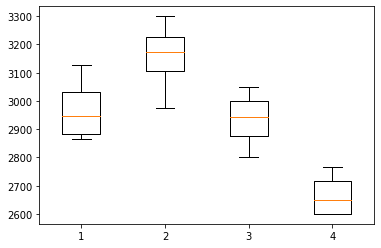

In [6]:
plt.boxplot([factor1, factor2, factor3, factor4])
plt.show()

((array([-1.72352605, -1.26569652, -0.97848645, -0.75533862, -0.56472935,
         -0.39279634, -0.23181469, -0.07666006,  0.07666006,  0.23181469,
          0.39279634,  0.56472935,  0.75533862,  0.97848645,  1.26569652,
          1.72352605]),
  array([2600, 2600, 2700, 2765, 2800, 2865, 2890, 2900, 2975, 2985, 3000,
         3050, 3129, 3150, 3200, 3300])),
 (218.8291760709089, 2931.8125, 0.9934854216475537))

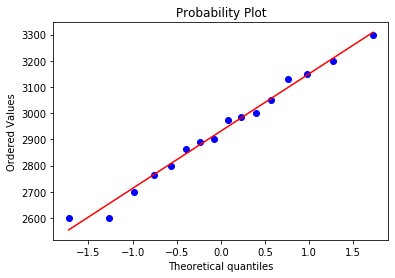

In [7]:
stats.probplot(data['Observations'], plot=plt)

## Residuals vs. Fitted Values Plot
Plot $\hat{y}_{ij}$ and $y_{ij} - \hat{y}_{ij}$

In [8]:
preds = data['Observations'].groupby(data['MixingTechnique']).agg('mean')
data['Preds'] = data.apply(lambda row: preds[ row.MixingTechnique ], axis=1)
data

,MixingTechnique,Observations,Preds
0,1,3129,2971.00
1,1,3000,2971.00
2,1,2865,2971.00
3,1,2890,2971.00
4,2,3200,3156.25
5,2,3300,3156.25
6,2,2975,3156.25
7,2,3150,3156.25
8,3,2800,2933.75
9,3,2900,2933.75


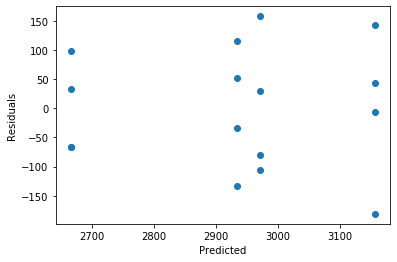

In [9]:
residuals = data['Observations'] - data['Preds']
plt.scatter(data['Preds'], residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

In [10]:
stats.bartlett(factor1, factor2, factor3, factor4)

BartlettResult(statistic=0.7115812650481363, pvalue=0.8704765970663918)

## 95% one-at-a-time Confidence Intervals

In [11]:
def construct_interval(i, alpha):
    t_val = abs(stats.t.ppf(alpha/2, N-a))
    lower = preds[i] - t_val * (MS_e / n)**0.5
    upper = preds[i] + t_val * (MS_e / n)**0.5
    print(f"Technique {i}: ({lower}, {upper})")

In [12]:
for i in range(1, 5):
    construct_interval(i, 0.05)

Technique 1: (2847.6241223041056, 3094.3758776958944)
Technique 2: (3032.8741223041056, 3279.6258776958944)
Technique 3: (2810.3741223041056, 3057.1258776958944)
Technique 4: (2542.8741223041056, 2789.6258776958944)


In [13]:
alpha = 0.05
t_val = abs(stats.t.ppf(alpha/2, N-a))
lower = preds[1] - preds[3] - t_val * (2*MS_e/n)**0.5
upper = preds[1] - preds[3] + t_val * (2*MS_e/n)**0.5
print(lower, upper)

-137.2298395072181 211.7298395072181


# Problem 2

In [14]:
data2 = pd.DataFrame({
    'CarType': [1]*10 + [2]*10 + [3]*10 + [4]*10,
    'Observations': [
        3, 5, 3, 7, 6, 5, 3, 2, 1, 6,
        1, 3, 4, 7, 5, 6, 3, 2, 1, 7,
        4, 1, 3, 5, 7, 1, 2, 4, 2, 7,
        3, 5, 7, 5, 10, 3, 4, 7, 2, 7
    ]
})
data2.describe()

,CarType,Observations
count,40.000000,40.000000
mean,2.500000,4.225000
std,1.132277,2.247363
min,1.000000,1.000000
25%,1.750000,2.750000
50%,2.500000,4.000000
75%,3.250000,6.000000
max,4.000000,10.000000


In [15]:
preds = data2['Observations'].groupby(data2['CarType']).agg('mean')
preds

CarType
1    4.1
2    3.9
3    3.6
4    5.3
Name: Observations, dtype: float64

In [16]:
n = 10
a = 4
N = n*a
SS_treatments = n * sum([(data2[data2.CarType == i+1].Observations.mean() - data2.Observations.mean())**2 for i in range(a)])
MS_treatments = SS_treatments / (a-1)
SS_T = sum([(data2.Observations.iloc[i] - data2.Observations.mean())**2 for i in range(data2.shape[0])])
SS_e = SS_T - SS_treatments
MS_e = SS_e / (N-a)
F_0 = MS_treatments / MS_e
p_value = 1 - stats.f.cdf(F_0, a-1, N-a)
print("Summary")
print(f"n = {n}, a = {a}, N = {N}")
print(f"SS_treatments = {SS_treatments}, MS_treatments = {MS_treatments}")
print(f"SS_T = {SS_T}")
print(f"SS_e = {SS_e}, MS_e = {MS_e}")
print(f"F_0 = {F_0}")
print(f"P value = {p_value}")

Summary
n = 10, a = 4, N = 40
SS_treatments = 16.674999999999997, MS_treatments = 5.558333333333333
SS_T = 196.97499999999997
SS_e = 180.29999999999995, MS_e = 5.008333333333332
F_0 = 1.1098169717138104
P value = 0.3578235508277888


In [17]:
factor1 = data2['Observations'][data2['CarType'] == 1]
factor2 = data2['Observations'][data2['CarType'] == 2]
factor3 = data2['Observations'][data2['CarType'] == 3]
factor4 = data2['Observations'][data2['CarType'] == 4]

stats.f_oneway(factor1, factor2, factor3, factor4)

F_onewayResult(statistic=1.1098169717138102, pvalue=0.35782355082778844)

((array([-2.11583547, -1.7314906 , -1.50271646, -1.33321868, -1.19520249,
         -1.07683093, -0.97189321, -0.87669641, -0.78885043, -0.70670905,
         -0.62908229, -0.55507545, -0.48399287, -0.41527745, -0.34847074,
         -0.28318561, -0.2190868 , -0.15587657, -0.09328369, -0.03105452,
          0.03105452,  0.09328369,  0.15587657,  0.2190868 ,  0.28318561,
          0.34847074,  0.41527745,  0.48399287,  0.55507545,  0.62908229,
          0.70670905,  0.78885043,  0.87669641,  0.97189321,  1.07683093,
          1.19520249,  1.33321868,  1.50271646,  1.7314906 ,  2.11583547]),
  array([0.44684138, 0.44684138, 0.44684138, 0.44684138, 0.44684138,
         0.89368277, 0.89368277, 0.89368277, 0.89368277, 0.89368277,
         1.34052415, 1.34052415, 1.34052415, 1.34052415, 1.34052415,
         1.34052415, 1.34052415, 1.34052415, 1.78736553, 1.78736553,
         1.78736553, 1.78736553, 2.23420691, 2.23420691, 2.23420691,
         2.23420691, 2.23420691, 2.23420691, 2.6810483 , 2.68

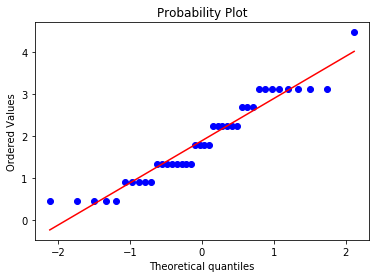

In [18]:
stats.probplot(data2['Observations']/(MS_e)**0.5, plot=plt)

In [19]:
stats.levene(factor1, factor2, factor3, factor4)

LeveneResult(statistic=0.06666666666666662, pvalue=0.9772360086502296)

In [20]:
alpha = 0.05
t_val = abs(stats.t.ppf(alpha/2, N-a))
lower = preds[2] - preds[4] - t_val * (2*MS_e/n)**0.5
upper = preds[2] - preds[4] + t_val * (2*MS_e/n)**0.5
print(lower, upper)

-3.429783375701517 0.6297833757015172


In [21]:
lower = preds[3] - t_val * (MS_e/n)**0.5
upper = preds[3] + t_val * (MS_e/n)**0.5
print(lower, upper)

2.1647264107017357 5.0352735892982645
